In [1]:
import os
import yaml
import shutil
from tqdm import tqdm
from datetime import datetime

In [2]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [3]:
HOME = os.getcwd()

!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt

In [4]:
from ultralytics import YOLOv10
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

In [5]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.

In [6]:
from roboflow import Roboflow

# dataset from https://universe.roboflow.com/great-barrier-reef/great-barrier-reef-o5scc
ROBOFLOW_API_KEY = "rWU1eQHaSgCK3DzRY2TP"
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("great-barrier-reef").project("great-barrier-reef-o5scc")
dataset = project.version(5).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Great-Barrier-Reef-5 in yolov8:: 100%|██████████| 9838/9838 [00:01<00:00, 7596.82it/s]


In [7]:
!mkdir datasets/ 

In [8]:
!mv {HOME}/Great-Barrier-Reef-5 datasets/

In [9]:
# replace class 'json' to 'starfish' in data.yaml
DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['names'] = ['starfish']
data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'valid/images'
data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [10]:
!cat datasets/Great-Barrier-Reef-5/data.yaml

names:
- starfish
nc: 1
roboflow:
    license: CC BY 4.0
    project: great-barrier-reef-o5scc
    url: https://universe.roboflow.com/great-barrier-reef/great-barrier-reef-o5scc/dataset/5
    version: 5
    workspace: great-barrier-reef
test: /kaggle/working/datasets/Great-Barrier-Reef-5/test/images
train: /kaggle/working/datasets/Great-Barrier-Reef-5/train/images
val: /kaggle/working/datasets/Great-Barrier-Reef-5/valid/images


In [11]:
!cat /kaggle/working/datasets/Great-Barrier-Reef-5/README.roboflow.txt


Great Barrier Reef - v5 2022-04-27 9:32am

This dataset was exported via roboflow.com on August 19, 2023 at 5:12 AM GMT

Roboflow is an end-to-end computer vision platform that helps you
* collaborate with your team on computer vision projects
* collect & organize images
* understand and search unstructured image data
* annotate, and create datasets
* export, train, and deploy computer vision models
* use active learning to improve your dataset over time

For state of the art Computer Vision training notebooks you can use with this dataset,
visit https://github.com/roboflow/notebooks

To find over 100k other datasets and pre-trained models, visit https://universe.roboflow.com

The dataset includes 4917 images.
Sea-Stars-COTS are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 416x416 (Stretch)

No image augmentation techniques were applied.




In [12]:
def label_path_to_bbox(label_path: str, normalized=True) -> list:
    with open(label_path, 'r') as file:
        # Read the content of the file
        file_content = file.read()
        
    detections = file_content.split('\n')
#     print(detections)
    str_boxes = [str_box.split(' ') for str_box in detections]
#     print(str_boxes)
    
    bboxes = []
    
    if normalized == False:
        image_path = label_path.replace('.txt','.jpg').replace( "labels", "images")
        image_width, image_height = Image.open(image_path).size
    
    for str_box in str_boxes:
        str_box_no_class = str_box[1:]
        float_box = [float(value) for value in str_box_no_class]
        
        if normalized == False:
            x_center = float_box[0] * image_width
            y_center = float_box[1] * image_height
            width = float_box[2] * image_width
            height = float_box[3] * image_height
            float_box = [x_center, y_center, width, height]
           
        bboxes.append(float_box)
        
    return bboxes    

In [13]:
def plot_image_with_bboxes(image, bboxes, normalized=True):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    # Display the image
    ax.imshow(image)
    # Get image dimensions
    image_width, image_height = image.size
    # Plot each bounding box
    for bbox in bboxes:
        if normalized == False:
            x_center = bbox[0]
            y_center = bbox[1]
            width = bbox[2]
            height = bbox[3]
        else:   
            x_center = bbox[0] * image_width
            y_center = bbox[1] * image_height
            width = bbox[2] * image_width
            height = bbox[3] * image_height
        
        # Calculate the top-left corner of the rectangle
        top_left_x = x_center - width / 2
        top_left_y = y_center - height / 2
        
        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
#         ax.plot(x_center, y_center, 'ro')  # 'ro' means red color and circle marker

    plt.axis('off')
    plt.show()

In [14]:
def display_image_path_with_label_path(image_path, label_path):
    with open(label_path, 'r') as file:
        # Read the content of the file
        file_content = file.read()

    bboxes = label_path_to_bbox(label_path)

    # Load the image
    image = Image.open(image_path)
    
    # display images with annotations
    plot_image_with_bboxes(image, bboxes)

image path: /kaggle/working/datasets/Great-Barrier-Reef-5/train/images/0-9761_jpg.rf.5d49e69a40fe53102861b0a2bf365faf.jpg


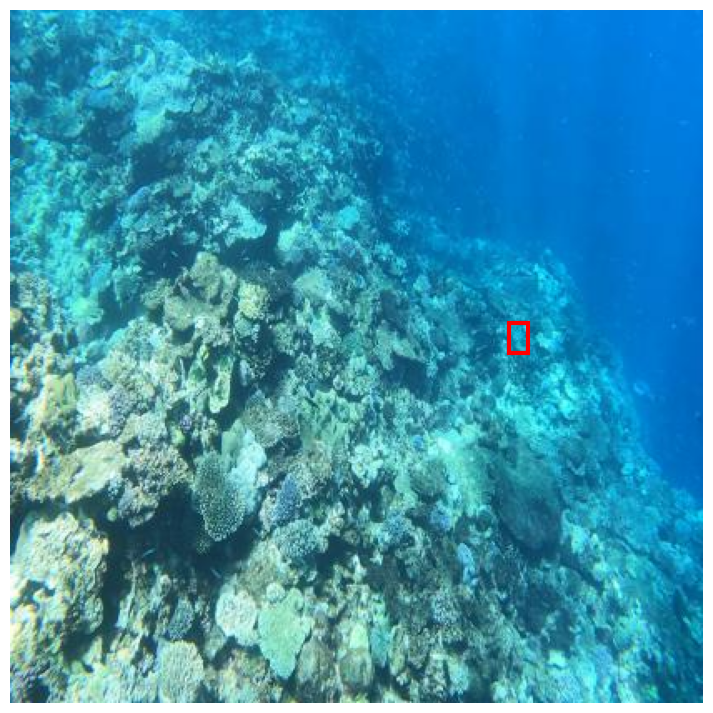

bbox: [[304.5, 196.5, 11.5, 18.0]]
normalized bbox: [[0.7319711538461539, 0.4723557692307692, 0.027644230769230768, 0.04326923076923077]]


In [15]:
import random

IMAGE_PATH = DATASET_PATH + 'train/images'

train_images = os.listdir(IMAGE_PATH)

random_image = random.choice(train_images)
# print(random_image)
image_path = os.path.join(IMAGE_PATH, random_image)
label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")
print(f"image path: {image_path}")

display_image_path_with_label_path(image_path, label_path)

print(f"bbox: {label_path_to_bbox(label_path, normalized=False)}")
print(f"normalized bbox: {label_path_to_bbox(label_path)}")

In [16]:
os.environ['WANDB_DISABLED'] = 'true'

In [17]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [18]:
!pip install optuna

In [19]:
os.environ['WANDB_DISABLED'] = 'true'

In [20]:
print(os.environ['WANDB_DISABLED'])

true


In [21]:
os.environ['WANDB_MODE'] = 'disabled'

In [30]:
!rm -rf /kaggle/working/runs/detect

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


In [ ]:
import optuna
import subprocess
import yaml
import os

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.002)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSProp"])
    disabled_aug = {'augment': False,
                    'hsv_h': 0,
                    'hsv_s': 0,
                    'hsv_v': 0,
                    'degrees': 0,
                    'translate': 0,
                    'scale': 0,
                    'shear': 0,
                    'perspective': 0,
                    'flipud': 0,
                    'fliplr': 0,
                    'mosaic': 0,
                    'mixup': 0,
                    'erasing': 0.0,
                    'crop_fraction':0.0,
                   }
    
    enabled_aug = {'augment': True, 
                    'hsv_h': 0.015,
                    'hsv_s': 0.7,
                    'hsv_v': 0.4,
                    'degrees': 30.0,
                    'translate': 0,
                    'scale': 0,
                    'shear': 0,
                    'perspective': 0,
                    'flipud': 0,
                    'fliplr': 0,
                    'mosaic': 0,
                    'mixup': 0,
                    'erasing': 0.0,
                    'crop_fraction':0.0,
                   }
    
    augmentations = trial.suggest_categorical('augment', [True, False])
#     augmentations = trial.suggest_categorical('augment', [disabled_aug, ])
    model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
    
    if augmentations == True:
        results = model.train(data=DATASET_PATH + 'data.yaml',
                                epochs=2,
                                imgsz=640,
                                batch=32,
                                lr0=learning_rate,
                                momentum=0.9,
                                optimizer=optimizer_name,
                                patience=10,
                                **enabled_aug,
                                )
        
    else:
        results = model.train(data=DATASET_PATH + 'data.yaml',
                                epochs=2,
                                imgsz=640,
                                batch=32,
                                lr0=learning_rate,
                                momentum=0.9,
                                optimizer=optimizer_name,
                                patience=10,
                                **disabled_aug,
                                )
        
    metrics = model.val(data=DATASET_PATH + 'data.yaml')
    fitness = 0.2 * metrics.results_dict['metrics/recall(B)'] + 0.2 * metrics.results_dict['metrics/mAP50(B)'] + 0.6 * metrics.results_dict['metrics/mAP50-95(B)'] 
    val_loss = fitness # Run validation on a set specified as 'val' argument
    
    return val_loss

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Get the best hyperparameters
print("Best hyperparameters: ", study.best_params)

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
!pip install supervision